In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision.transforms import ToTensor
from torchvision import transforms

In [2]:
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder

dataset = load_dataset("Isamu136/big-animal-dataset")

captions = dataset['train']['caption']
le = LabelEncoder()
caption_ids = le.fit_transform(captions)
dataset['train'] = dataset['train'].add_column('lable', caption_ids)
dataset['train'] = dataset['train'].remove_columns("caption")

In [3]:
dataset = dataset["train"].train_test_split(test_size=0.2)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'lable'],
        num_rows: 49719
    })
    test: Dataset({
        features: ['image', 'lable'],
        num_rows: 12430
    })
})

In [39]:
from torch.utils.data import Dataset

class ToRGB(object):
    def __call__(self, img):
        return img.convert('RGB')

transform_train = transforms.Compose([
    ToRGB(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

class AnimalDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        caption_id = self.dataset[idx]['lable']
        if self.transform:
            image = self.transform(image)
        return image, caption_id

train_dataset = AnimalDataset(dataset['train'], transform=transform_train)
test_dataset  = AnimalDataset(dataset['test'], transform=transform_train)

In [40]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)



In [41]:
import numpy as np
caption_ids = np.array(dataset['train']['lable'])
num_classes = np.unique(caption_ids).size

In [42]:
num_classes

163

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=163):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [44]:
def ResNet18():
    return ResNet(ResidualBlock)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [47]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [48]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [49]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 5.258607  [   64/49719]
loss: 4.413439  [ 6464/49719]
loss: 3.921274  [12864/49719]
loss: 4.134905  [19264/49719]
loss: 4.368319  [25664/49719]
loss: 4.051318  [32064/49719]
loss: 4.442844  [38464/49719]
loss: 4.019533  [44864/49719]
Test Error: 
 Accuracy: 15.4%, Avg loss: 4.028605 

Epoch 2
-------------------------------
loss: 4.156716  [   64/49719]
loss: 3.933508  [ 6464/49719]
loss: 3.801604  [12864/49719]
loss: 3.938472  [19264/49719]
loss: 4.288679  [25664/49719]
loss: 3.972181  [32064/49719]
loss: 4.333819  [38464/49719]
loss: 3.925772  [44864/49719]
Test Error: 
 Accuracy: 15.8%, Avg loss: 4.009222 

Epoch 3
-------------------------------
loss: 4.177474  [   64/49719]
loss: 3.896525  [ 6464/49719]
loss: 3.840817  [12864/49719]
loss: 3.898150  [19264/49719]
loss: 4.211332  [25664/49719]
loss: 4.000181  [32064/49719]
loss: 4.265322  [38464/49719]
loss: 3.909935  [44864/49719]
Test Error: 
 Accuracy: 16.2%, Avg loss: 3.989181 

Epoc

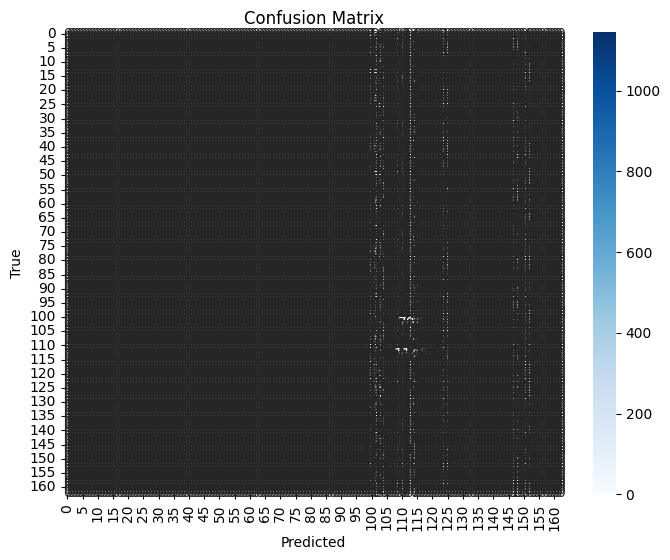

In [54]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán toàn bộ testset
all_preds = []
all_labels = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tạo confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()